first 15 hidden states:  tf.Tensor([1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.], shape=(15,), dtype=float32)
hidden state shape:  (1, 20)
v0 state shape:   (3273,)
v1 state shape:   (3273,)
error 0.50259703
Epoch: 1 batch #: 0  of 84 sample #: 499 reconstruction error: 0.002750
Epoch: 1 batch #: 1  of 84 sample #: 499 reconstruction error: 0.002750
Epoch: 1 batch #: 2  of 84 sample #: 499 reconstruction error: 0.002444
Epoch: 1 batch #: 3  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 4  of 84 sample #: 499 reconstruction error: 0.001833
Epoch: 1 batch #: 5  of 84 sample #: 499 reconstruction error: 0.012527
Epoch: 1 batch #: 6  of 84 sample #: 499 reconstruction error: 0.006416
Epoch: 1 batch #: 7  of 84 sample #: 499 reconstruction error: 0.000917
Epoch: 1 batch #: 8  of 84 sample #: 499 reconstruction error: 0.002139
Epoch: 1 batch #: 9  of 84 sample #: 499 reconstruction error: 0.001528
Epoch: 1 batch #: 10  of 84 sample #: 499 reconstruction error: 0.01069

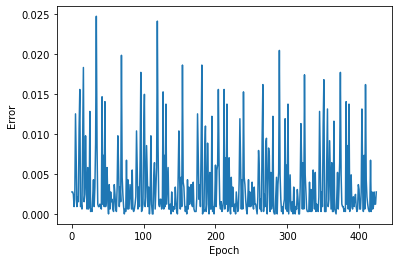

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Apr/2021 20:55:57] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [19/Apr/2021 20:55:57] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Apr/2021 20:56:02] "GET /sampleapi/printcust?mock_user_id=144 HTTP/1.1" 200 -


tf.Tensor([0. 1. 0. ... 0. 0. 0.], shape=(3273,), dtype=float32)
tf.Tensor([0.00609986 0.00409693 0.00673689 ... 0.00091693 0.00050345 0.00061483], shape=(3273,), dtype=float32)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3273,), dtype=float32)
tf.Tensor(
[1.0359016e-03 8.9131651e-04 4.5757121e-03 ... 4.2210686e-05 8.9554987e-06
 9.0829344e-06], shape=(3273,), dtype=float32)


127.0.0.1 - - [19/Apr/2021 20:57:12] "GET /sampleapi/printcust?mock_user_id=24 HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2021 20:57:17] "GET /sampleapi/printcust?mock_user_id=65 HTTP/1.1" 200 -


tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3273,), dtype=float32)
tf.Tensor(
[3.5570997e-03 3.8103573e-04 1.2909479e-03 ... 3.1832107e-05 7.5614180e-06
 9.2786458e-06], shape=(3273,), dtype=float32)


127.0.0.1 - - [19/Apr/2021 20:57:20] "GET /sampleapi/printcust?mock_user_id=87 HTTP/1.1" 200 -


tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3273,), dtype=float32)
tf.Tensor(
[1.4400731e-03 4.8213481e-04 8.3654851e-04 ... 1.4533968e-05 4.5295992e-06
 5.6045369e-06], shape=(3273,), dtype=float32)


In [ ]:
from flask import Flask, jsonify, request
import os
import os.path
import json
import sys
import pandas as pd
import numpy as np
from operator import itemgetter
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import time
from itertools import combinations

#pytesseract.pytesseract.tesseract_cmd="D:\\Program Files\\Tesseract-OCR\\tesseract.exe"
 
app = Flask(__name__)

customer_df = pd.read_csv('customerdata.csv',low_memory=False)
items_df = customer_df[["product_item_id", "PRODUCT_NAME", "CATEGORY"]]
items_df = items_df.drop_duplicates()
items_df = items_df.reset_index(drop = True)
items_df = pd.DataFrame(items_df.groupby('product_item_id')["PRODUCT_NAME"].apply(list)).reset_index()
purchase_df=customer_df.groupby(['CUSTOMER_ID','product_item_id']).size().reset_index(name='COUNT')
purchase_df['COUNT'] = 1
user_item_df = purchase_df.pivot(index='CUSTOMER_ID', columns='product_item_id', values='COUNT')
user_item_df.shape
user_item_df.fillna(0).values.max()
norm_item_purchase = user_item_df.fillna(0)
trX = norm_item_purchase.values
trX[0:5]

hiddenUnits = 20
visibleUnits =  len(user_item_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique movies
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

v0 = tf.zeros([visibleUnits], tf.float32)
#testing to see if the matrix product works
tf.matmul([v0], W)

#Phase 1: Input Processing
#defining a function to return only the generated hidden states
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

#printing output of zeros input
h0 = hidden_layer(v0, W, hb)
print("first 15 hidden states: ", h0[0][0:15])

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb)
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

start_time=time.time()
epochs = 5 #change to 5
batchsize = 500 #change to 500
errors = []
weights = []
K=1
alpha = 0.1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)



#for i in range(epochs):
#    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
#        batch = trX[start:end]
#        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        prv_w = cur_w
#        prv_vb = cur_vb
#        prv_hb = cur_hb
#    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
#    print (errors[-1])
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):          
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1),
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize),
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1




plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

@app.route('/sampleapi/<string:typeofscript>', methods = ['GET','POST'])
def disp(typeofscript):
    ## AADAR CARD FACE RECOGNITION
    if typeofscript=='printcust':
        user_id = request.args.get('mock_user_id')
        user_id=int(user_id)
       
       
        mock_user_id = user_id
        # customer_df[(CUSTOMER_ID[mock_user_id]]
        # customer_df.loc[mock_user_id]
        customer_df.loc[customer_df['CUSTOMER_ID'] == mock_user_id].groupby(['CUSTOMER_ID','PRODUCT_NAME']).size().reset_index(name='COUNT')

        #Selecting the input user
        inputUser = trX[mock_user_id-1].reshape(1, -1)

        inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32")
        v0 = inputUser

        print(v0)
        v0.shape

        v0test = tf.zeros([visibleUnits], tf.float32)
        v0test.shape

        #Feeding in the user and reconstructing the input

        hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb)

        vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

        rec = vv1

        tf.maximum(rec,1)
        for i in vv1:
            print(i)

        scored_items_df_mock = items_df[items_df['product_item_id'].isin(user_item_df.columns)]
        scored_items_df_mock = scored_items_df_mock.assign(RecommendationScore = rec[0])
        scored_items_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

        items_df_mock = purchase_df[purchase_df['CUSTOMER_ID'] == mock_user_id]
        items_df_mock.head()

        #Merging movies_df with ratings_df by MovieID
        merged_df_mock = scored_items_df_mock.merge(items_df_mock, on='product_item_id', how='outer').drop(columns=['CUSTOMER_ID', 'COUNT'])

        final=merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

                #print(time.time()-start_time)
        return final.to_json(orient='records')
if __name__ == '__main__':
    app.run(debug = True,use_reloader=False,threaded=True)